In [2]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation, LinearTriInterpolator
import rasterio
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd

In [3]:
def geometry (csvpath): 
    """
    takes the cvs output file and generates a geodataframe with the elevation and coordinates of every point 
    """
    print ('===================READING CSV  =====================')
    pan = pd.read_csv(csvpath)
    
    geo = pan[["X","Y","Z"]]
    
    #convert xyz to geodataframe
    geometry = [Point(xy) for xy in zip(pd.to_numeric(geo['X']), pd.to_numeric(geo['Y']))]
    gdf = gpd.GeoDataFrame(geo, crs='epsg:4326',geometry=geometry)
    gdf = gdf[["Z", "geometry"]]
    gdf = gdf.rename(columns={"Z": "elevation_m", "geometry": "geometry"})
    #gdf.to_csv("../csv/"+region+".csv")
    
    return gdf 

In [4]:
points3d = geometry('../csv/IA_FullState.csv')


===================READING CSV  =====================


In [5]:
points3d.head()

,elevation_m,geometry
0,272.70,POINT (-10423180.010 5165777.620)
1,272.80,POINT (-10423175.180 5165778.530)
2,273.10,POINT (-10423172.820 5165779.010)
3,272.70,POINT (-10423177.630 5165779.270)
4,272.54,POINT (-10423180.020 5165778.810)


In [6]:
totalPointsArray = np.zeros([points3d.shape[0],3])
#iteration over the geopandas dataframe
for index, point in points3d.iterrows():
    pointArray = np.array([point.geometry.coords.xy[0][0],point.geometry.coords.xy[1][0],point['elevation_m']])
    totalPointsArray[index] = pointArray
totalPointsArray[:5,:]

array([[-1.04231800e+07,  5.16577762e+06,  2.72700000e+02],
       [-1.04231752e+07,  5.16577853e+06,  2.72800000e+02],
       [-1.04231728e+07,  5.16577901e+06,  2.73100000e+02],
       [-1.04231776e+07,  5.16577927e+06,  2.72700000e+02],
       [-1.04231800e+07,  5.16577881e+06,  2.72540000e+02]])

In [7]:
#triangulation function
triFn = Triangulation(totalPointsArray[:,0],totalPointsArray[:,1])
#linear triangule interpolator funtion
linTriFn = LinearTriInterpolator(triFn,totalPointsArray[:,2])

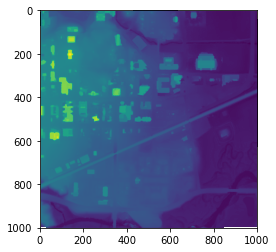

In [8]:
#define raster resolution in (m)
rasterRes = 2

xCoords = np.arange(totalPointsArray[:,0].min(), totalPointsArray[:,0].max()+rasterRes, rasterRes)
yCoords = np.arange(totalPointsArray[:,1].min(), totalPointsArray[:,1].max()+rasterRes, rasterRes)
zCoords = np.zeros([yCoords.shape[0],xCoords.shape[0]])

#loop among each cell in the raster extension
for indexX, x in np.ndenumerate(xCoords):
    for indexY, y in np.ndenumerate(yCoords):
        tempZ = linTriFn(x,y)
        #filtering masked values
        if tempZ == tempZ:
            zCoords[indexY,indexX]=tempZ
        else:
            zCoords[indexY,indexX]=np.nan

#preliminary representation of the interpolated values
plt.imshow(zCoords)

In [9]:
#definition of the raster transform array
from rasterio.transform import Affine
transform = Affine.translation(xCoords[0] - rasterRes/2, yCoords[0] - rasterRes/2) * Affine.scale(rasterRes, rasterRes)
transform



Affine(2.0, 0.0, -10425172.94,
       0.0, 2.0, 5164493.71)

In [10]:
#get crs as wkt
from rasterio.crs import CRS
rasterCrs = CRS.from_epsg(32718)
rasterCrs.data

{'init': 'epsg:32718'}

In [11]:
#definition, register and close of interpolated raster
triInterpRaster = rasterio.open('../tif/triangleInterpolation.tif',
                                'w',
                                driver='GTiff',
                                height=zCoords.shape[0],
                                width=zCoords.shape[1],
                                count=1,
                                dtype=zCoords.dtype,
                                #crs='+proj=latlong',
                                crs={'init': 'epsg:32718'},
                                transform=transform,
                                )
triInterpRaster.write(zCoords,1)
triInterpRaster.close()

In [ ]:
#interpolation over points
interpolatedPoints = points3d
interpolatedPoints['elevation_m'] = ''
for index, point in interpolatedPoints.iterrows():
    tempZ = linTriFn(point.geometry.coords.xy[0][0],point.geometry.coords.xy[1][0])
    if tempZ == tempZ:
        interpolatedPoints.loc[index,'elevation_m'] = float(tempZ)
    else:
        interpolatedPoints.loc[index,'elevation_m'] = np.nan

In [ ]:
#save as shapefile
interpolatedPoints.to_file('../shps/interpolatedPoints.shp')

In [ ]:
from rasterio.plot import show
src = rasterio.open("../rst/triangleInterpolation.tif")

fig, ax = plt.subplots(figsize=(24,16))
ax.set_xlim(624000,624600)
ax.set_ylim(8359400,8359800)
points3d.plot(ax=ax, marker='D',markersize=50, color='gold')
interpolatedPoints.plot(ax=ax, markersize=10, color='orangered')
show(src)
plt.show()